In [1]:
%matplotlib inline

In [2]:
import numpy as np
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, TimeDistributed
from keras.layers import LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import scipy as scipy
from keras.callbacks import TensorBoard
from keras.regularizers import l1, activity_l1
from keras.regularizers import l2, activity_l2
from sklearn import preprocessing  
#from datetime 
import datetime 
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
import pickle
from keras.preprocessing.sequence import pad_sequences
import time

Using TensorFlow backend.


In [3]:
numpy.random.seed(7)

In [4]:
df_train = pd.read_csv("../train.csv")
df_test = pd.read_csv("../test.csv")

In [5]:
df_train['month'] = pd.DatetimeIndex(df_train.datetime).month
df_train['day'] = pd.DatetimeIndex(df_train.datetime).dayofweek
df_train['hour'] = pd.DatetimeIndex(df_train.datetime).hour
df_train['year'] = pd.DatetimeIndex(df_train.datetime).year

df_test['month'] = pd.DatetimeIndex(df_test.datetime).month
df_test['day'] = pd.DatetimeIndex(df_test.datetime).dayofweek
df_test['hour'] = pd.DatetimeIndex(df_test.datetime).hour
df_test['year'] = pd.DatetimeIndex(df_test.datetime).year

In [6]:
# combine train and test data into one df
df = df_train.append(df_test)

# lowercase column names
#df.columns = map(str.lower, df.columns)

df['datetime'] = pd.to_datetime(df['datetime'])
df.index = df['datetime']

#df['month'] = pd.DatetimeIndex(df.datetime).month
#df['day'] = pd.DatetimeIndex(df.datetime).dayofweek
#df['hour'] = pd.DatetimeIndex(df.datetime).hour
#df['year'] = pd.DatetimeIndex(df.datetime).year

df = df.drop('datetime', axis=1)
drange = pd.date_range('2011-01-01 00:00:00', '2012-12-31 23:00:00', freq='H')
df = df.reindex(drange)

df = df[df_train.drop(['datetime', 'casual', 'registered','count'],axis=1).columns]

# parse datetime colum & add new time related columns
#dt = pd.DatetimeIndex(df['datetime'])
#df.set_index(dt, inplace=True)

dt = pd.DatetimeIndex(df_train['datetime'])
df_train.set_index(dt, inplace=True)
dt = pd.DatetimeIndex(df_test['datetime'])
df_test.set_index(dt, inplace=True)

df["weather"] = df["weather"].interpolate(method='time').apply(np.round)
df["temp"] = df["temp"].interpolate(method='time')
df["atemp"] = df["atemp"].interpolate(method='time')
df["humidity"] = df["humidity"].interpolate(method='time').apply(np.round)
df["windspeed"] = df["windspeed"].interpolate(method='time')

df["season"] = df["season"].interpolate(method='time').apply(np.round)
df["holiday"] = df["holiday"].interpolate(method='time').apply(np.round)
df["workingday"] = df["workingday"].interpolate(method='time').apply(np.round)

df["month"] = df["month"].interpolate(method='time').apply(np.round)
df["day"] = df["day"].interpolate(method='time').apply(np.round)
df["hour"] = df["hour"].interpolate(method='time').apply(np.round)
df["year"] = df["year"].interpolate(method='time').apply(np.round)

In [7]:
def get_day(day_start):
    day_end = day_start + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day_start, day_end, freq="H")

# tax day
df_train.loc[get_day(pd.datetime(2011, 4, 15)), "workingday"] = 1
df_train.loc[get_day(pd.datetime(2012, 4, 16)), "workingday"] = 1
# thanksgiving friday
df_test.loc[get_day(pd.datetime(2011, 11, 25)), "workingday"] = 0
df_test.loc[get_day(pd.datetime(2012, 11, 23)), "workingday"] = 0
# tax day
df_train.loc[get_day(pd.datetime(2011, 4, 15)), "holiday"] = 0
df_train.loc[get_day(pd.datetime(2012, 4, 16)), "holiday"] = 0

# thanksgiving friday
df_test.loc[get_day(pd.datetime(2011, 11, 25)), "holiday"] = 1
df_test.loc[get_day(pd.datetime(2012, 11, 23)), "holiday"] = 1

#storms
df_test.loc[get_day(pd.datetime(2012, 5, 21)), "holiday"] = 1
#tornado
df_train.loc[get_day(pd.datetime(2012, 6, 1)), "holiday"] = 1

In [8]:
df_train_train = df_train.drop(['datetime','casual','registered','count'], axis = 1)
#df_train_train = df_train_train.drop(['season','workingday','weather','holiday'], axis = 1)
df_test_train = df_train['count']

In [9]:
scaler = StandardScaler()
scaler.fit(df_test_train.values.astype('float32').reshape(-1,1))
scalerx = StandardScaler()
scalerx.fit(df_train_train.values.astype('float32'))
df = df.apply(lambda x: scalerx.fit_transform(x.reshape(-1,1)).reshape(1,-1)[0] )
timesteps = 2
def preprocess_nn(datax, datay):
    indexx = pd.DatetimeIndex(datax['datetime']).day 
    testindex = np.logical_or(np.logical_or(indexx == 19,indexx == 18),np.logical_or(indexx == 17, indexx == 16))
    datax[datax.drop('datetime',axis=1).columns] = datax[datax.drop('datetime',axis=1).columns].apply(lambda x: scalerx.fit_transform(x.reshape(-1,1)).reshape(1,-1)[0] )
    datay[datay.drop('datetime',axis=1).columns] = scaler.transform(datay[datay.drop('datetime',axis=1).columns])
    #train_Y_n = scaler.transform(datay.reshape(-1,1))
    train_x = datax[~testindex]#.astype('float32')
    train_y = datay[~testindex]#.astype('float32')
    test_x = datax[testindex]#.astype('float32')
    test_y = datay[testindex]#.astype('float32')
    return train_x, train_y, test_x, test_y
#def preshape_nn(data_x):
#    data_x = numpy.reshape(data_x, (data_x.shape[0]/timesteps, timesteps, data_x.shape[1]))
#    return data_x
def preshape_nn(data_set, look_back = timesteps):
    out1= []
    for val in range(len(data_set) - look_back + 1):
        end1 = datetime.datetime.strptime(data_set['datetime'].values[look_back - 1 + val],"%Y-%m-%d %H:%M:%S" )
        timesteps_array = []
        for it in range(look_back): 
            timesteps_array.append(np.datetime64(end1))
            end1 = end1 - datetime.timedelta(hours = 1)
        timesteps_array = timesteps_array[::-1]
        timestep_unit = df.loc[timesteps_array].values.astype('float32')
        #if val == 0:
         #   out = timestep_unit
        #    print out.shape
        #timestep_unit = np.array(timestep_unit,type('float32'))
        #out = np.stack([out,timestep_unit], axis=0)
        out1.append(timestep_unit)
    datax = np.stack(out1, axis=0)
    return datax
def preshape_nn_test(data_set, look_back = timesteps):
    out1= []
    for val in range(len(data_set)):
        end1 = datetime.datetime.strptime(data_set['datetime'].values[val],"%Y-%m-%d %H:%M:%S" )
        timesteps_array = []
        for it in range(look_back): 
            timesteps_array.append(np.datetime64(end1))
            end1 = end1 - datetime.timedelta(hours = 1)
        timesteps_array = timesteps_array[::-1]
        timestep_unit = df.loc[timesteps_array].values.astype('float32')
        #if val == 0:
         #   out = timestep_unit
        #    print out.shape
        #timestep_unit = np.array(timestep_unit,type('float32'))
        #out = np.stack([out,timestep_unit], axis=0)
        out1.append(timestep_unit)
    datax = np.stack(out1, axis=0)
    return datax
def preshape_nn_y(data_set, look_back = timesteps ):
    return data_set.drop('datetime',axis = 1).values[look_back - 1:]
def learn_nn(train_x, train_y, test_x, test_y, string):
    from keras.models import Sequential
    from keras.layers import LSTM, Dense
    import numpy as np    

    data_dim = train_x.shape[-1] -1
    
    #LSTM
    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()
    #model.add(Dense(100))
    model.add(LSTM(100, return_sequences=True,
                   input_shape=(timesteps, data_dim)))#, W_regularizer=l2(0.00001)))
    model.add(LSTM(50, return_sequences=True))#, W_regularizer=l2(0.00001)))
    model.add(LSTM(25, return_sequences=True))#, W_regularizer=l2(0.00001)))
    model.add(LSTM(10))  
    model.add(Dense(1, activation='linear'))    
    
    
    #####
    model.compile(loss='mean_squared_error',
                  optimizer='rmsprop')
    
    x_train = preshape_nn(train_x)
    y_train  = preshape_nn_y(train_y) #scaler.transform(train_y)


    x_val = preshape_nn(test_x)
    y_val = preshape_nn_y(test_y)#scaler.transform(test_y)
    # generate dummy validation data

    now = datetime.datetime.now()
    print now.strftime("%Y%m%d-%H%M%S")
    model.fit(x_train, y_train,
              batch_size=100, nb_epoch=100, verbose = 0,
              validation_data=(x_val, y_val),
              callbacks=[TensorBoard(log_dir='logs1/' + now.strftime("%Y%m%d-%H%M%S") + string + "/")])
    model.save("models/" + now.strftime("%Y%m%d-%H%M%S") + ".h5")
    return model
def model_eval_nn(model, prepro):
    trainScore = math.sqrt(mean_squared_error(scaler.inverse_transform(model.predict(preshape_nn(prepro[0]))), scaler.inverse_transform(preshape_nn_y(prepro[1]))))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore =  math.sqrt(mean_squared_error(scaler.inverse_transform(model.predict(preshape_nn(prepro[2]))), scaler.inverse_transform(preshape_nn_y(prepro[3]))))
    print('Test Score: %.2f RMSE' % (testScore)) 
    plt.plot(scaler.inverse_transform(model.predict(preshape_nn(prepro[2]))).reshape(-1,1) - scaler.inverse_transform(preshape_nn_y(prepro[3])).reshape(-1,1),'.')
def get_rmsle(model, prepro):
    diff = pd.DataFrame(np.log(scaler.inverse_transform(model.predict(preshape_nn(prepro[2]))).astype('float32') + 1) - np.log(scaler.inverse_transform(preshape_nn_y(prepro[3])).astype('float32') + 1))
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error).values[0]

In [10]:
datax = df_train.drop(['casual','registered','count'], axis = 1)
datay = df_train[['datetime','count']]
pre1 = preprocess_nn(datax,datay)

/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was conv

20170114-104712
Train Score: 26.77 RMSE
Test Score: 51.05 RMSE


0.35813585

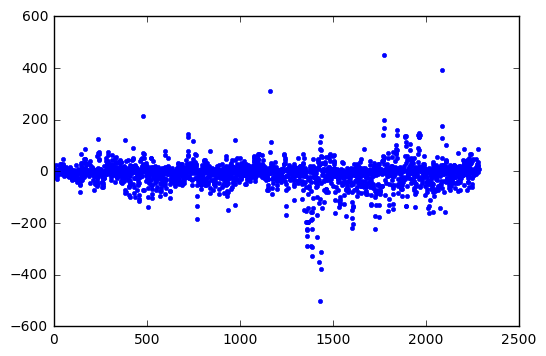

In [11]:
m1 = learn_nn(pre1[0],pre1[1],pre1[2],pre1[3],'MG')
model_eval_nn(m1,pre1)
get_rmsle(m1,pre1)

In [12]:
df_test_test = df_test.copy()#.drop(['datetime'], axis = 1)
#df_test_test = df_test_test.drop(['season','workingday','weather','holiday'], axis = 1)
#df_test_t = df_test_test.apply(lambda x: scalerx.fit_transform(x.reshape(-1,1)).reshape(1,-1)[0] )
df_test_test[df_test_test.drop('datetime',axis=1).columns] = df_test_test[df_test_test.drop('datetime',axis=1).columns].apply(lambda x: scalerx.fit_transform(x.reshape(-1,1)).reshape(1,-1)[0] )
df_test_r = preshape_nn_test(df_test_test)

/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was conv

In [13]:
pred = m1.predict(df_test_r)
out = scaler.inverse_transform(pred).astype(int)
#from keras.models import load_model
#mr = load_model('models/20170113-190313.h5')
#df_test_r_r = preshape_nn(df_test_test,1)
#predr = scaler.inverse_transform(mr.predict(df_test_r_r)).astype(int)[range(timesteps-1)]
#out = np.append(predr,out)
out[out<=0] = 0
out = out[:,0]
pred = pd.DataFrame({'datetime': df_test['datetime'],'count': out})
pred = pred[['datetime','count']]
pred.to_csv("pred.csv", index = False)

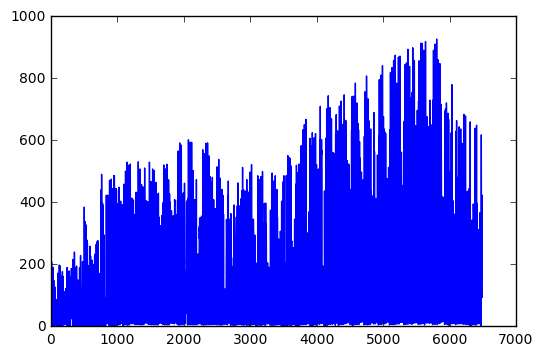

In [14]:
plt.plot(out)

[ 0.99060308]


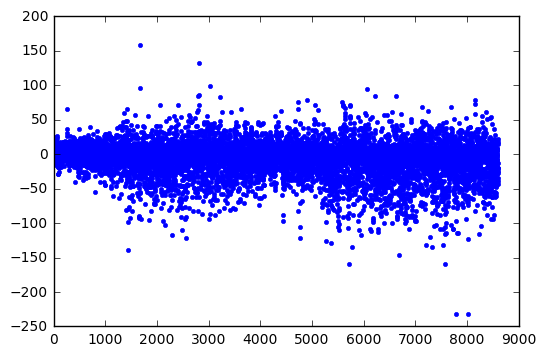

In [15]:
plt.plot(scaler.inverse_transform(m1.predict(preshape_nn(pre1[0])))-scaler.inverse_transform(preshape_nn_y(pre1[1])).reshape(-1,1),'.')
print scipy.stats.pearsonr(scaler.inverse_transform(m1.predict(preshape_nn(pre1[0]))),scaler.inverse_transform(preshape_nn_y(pre1[1])).reshape(-1,1))[0]

/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was conv

20170114-105004
Train Score: 8.52 RMSE
Test Score: 14.21 RMSE


0.67896509

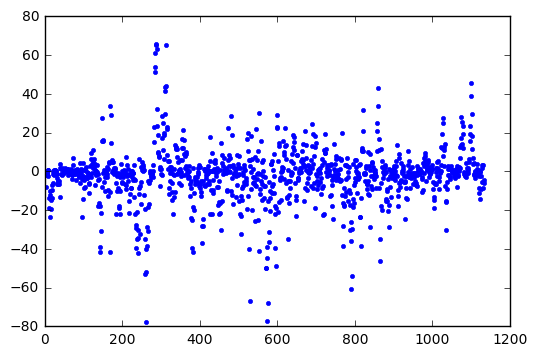

In [16]:
#indexx = pd.DatetimeIndex(df_train['datetime'][df_train['year'] == 2011]).day 
#testindex = np.logical_or(np.logical_or(indexx == 19,indexx == 18),np.logical_or(indexx == 17, indexx == 16))
pre2 = preprocess_nn(df_train.drop(['casual','registered','count'], axis = 1)[df_train['year'] == 2011],df_train[['datetime','casual']][df_train['year'] == 2011])
m2 = learn_nn(pre2[0],pre2[1],pre2[2],pre2[3],'MAC')
model_eval_nn(m2,pre2)
get_rmsle(m2,pre2)

/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was conv

20170114-105143
Train Score: 17.61 RMSE
Test Score: 28.98 RMSE


0.43179733

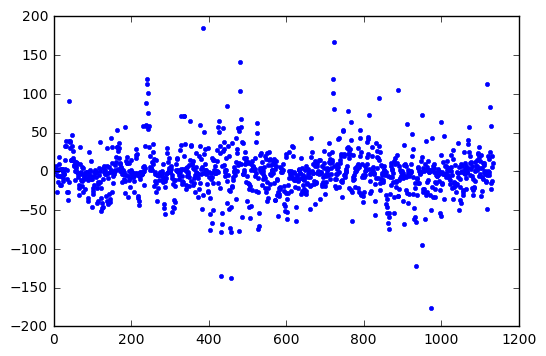

In [17]:
pre3 = preprocess_nn(df_train.drop(['casual','registered','count'], axis = 1)[df_train['year'] == 2011],df_train[['datetime','registered']][df_train['year'] == 2011])
m3 = learn_nn(pre3[0],pre3[1],pre3[2],pre3[3],'MAR')
model_eval_nn(m3,pre3)
get_rmsle(m3,pre3)

/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was conv

20170114-105330
Train Score: 11.54 RMSE
Test Score: 26.40 RMSE


0.86654103

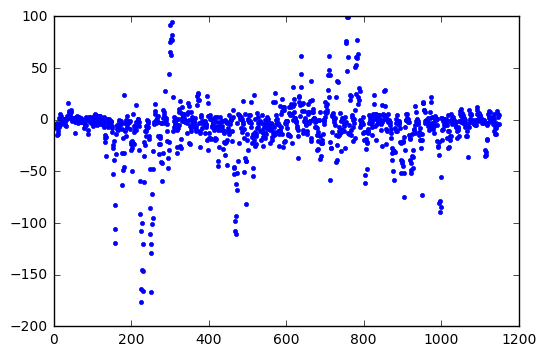

In [18]:
#indexx = pd.DatetimeIndex(df_train['datetime'][df_train['year'] == 2012]).day 
#testindex = np.logical_or(np.logical_or(indexx == 19,indexx == 18),np.logical_or(indexx == 17, indexx == 16))
pre4 = preprocess_nn(df_train.drop(['casual','registered','count'], axis = 1)[df_train['year'] == 2012],df_train[['datetime','casual']][df_train['year'] == 2012])
m4 = learn_nn(pre4[0],pre4[1],pre4[2],pre4[3],'MBC')
model_eval_nn(m4,pre4)
get_rmsle(m4,pre4)

/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was conv

20170114-105526
Train Score: 33.65 RMSE
Test Score: 55.18 RMSE


0.39629552

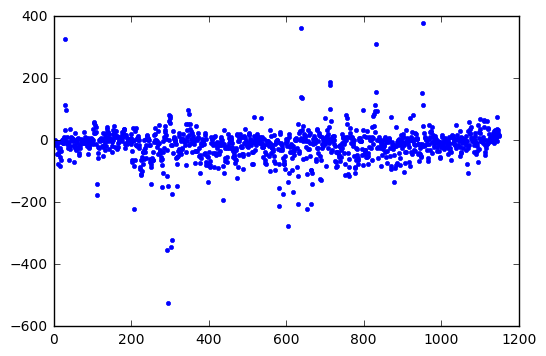

In [19]:
pre5 = preprocess_nn(df_train.drop(['casual','registered','count'], axis = 1)[df_train['year'] == 2012],df_train[['datetime','registered']][df_train['year'] == 2012])
m5 = learn_nn(pre5[0],pre5[1],pre5[2],pre5[3],'MBR')
model_eval_nn(m5,pre5)
get_rmsle(m5,pre5)

In [20]:
out2 = scaler.inverse_transform(m2.predict(preshape_nn_test(df_test[df_test['year']==2011]))).astype(int)
out3 = scaler.inverse_transform(m3.predict(preshape_nn_test(df_test[df_test['year']==2011]))).astype(int)
out4 = scaler.inverse_transform(m4.predict(preshape_nn_test(df_test[df_test['year']==2012]))).astype(int)
out5 = scaler.inverse_transform(m5.predict(preshape_nn_test(df_test[df_test['year']==2012]))).astype(int)
out2[out2<0] = 0
out3[out3<0] = 0
out4[out4<0] = 0
out5[out5<0] = 0
out2 = out2[:,0]
out3 = out3[:,0]
out4 = out4[:,0]
out5 = out5[:,0]

In [21]:
outb = np.concatenate((np.array(out2 + out3),np.array(out4 + out5)), axis = 0)
pred = pd.DataFrame({'datetime': df_test['datetime'],'count': outb})
pred = pred[['datetime','count']]
pred.to_csv("pred2.csv", index = False)

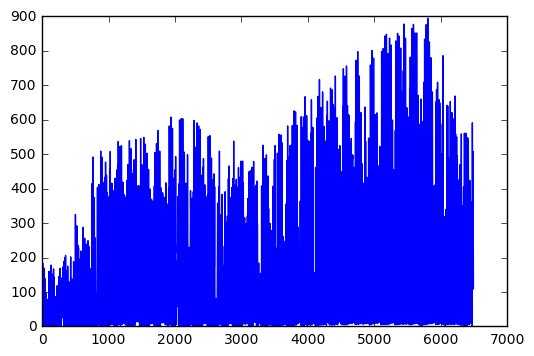

In [22]:
plt.plot(outb)

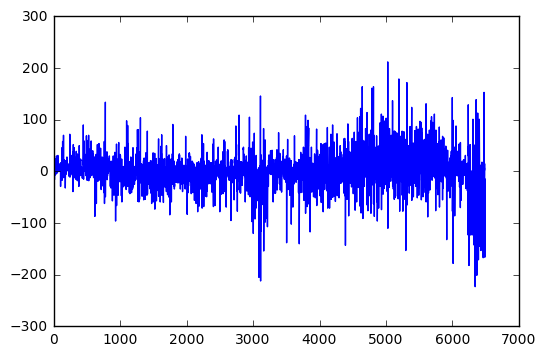

In [23]:
plt.plot(out-outb)